# Problem data generator for UE to FlyBS association

This code generates randomly positioned users and kmeans-clustered drones at a set and equal height and use a path loss model to generate a channel width matrix for the submodularity welfare problem of assigning users to drone base stations linked to a fixed base station.
A given number of pre-existing users will be linked to drones simply by linking them to the closest drone. After this, "free" users will have their path loss modeled and provided as a matrix.

In [1]:
# Libraries
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.collections as mcollections
from matplotlib import colors as mcolors
import sklearn
from sklearn.cluster import KMeans
import scipy
import scipy.stats as st
import time
print('Python: {}'.format(sys.version))
print('numpy: {}'.format(np.version.version))
print('matplotlib: {}'.format(matplotlib.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('scipy: {}'.format(scipy.__version__))

Python: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
numpy: 1.16.5
matplotlib: 3.1.1
sklearn: 0.21.3
scipy: 1.3.1


In [2]:
class Generator:
    def __init__(self, play_area):
        self.play_area = play_area        
        self.drones = []
        self.fixed_users = []
        self.new_users = []
    
    # Generate locations for users and drones
    def generate(self, drone_count, fixed_count, new_count,\
                drone_height):
        self.drone_to_user = np.empty((drone_count,new_count))
        self.base_to_drone = np.empty(drone_count)
        self.drone_count = drone_count+1 # (drone zero is base station)
        self.fixed_count = fixed_count
        self.new_count = new_count
        self.fixed_users = [np.array([np.random.random() * self.play_area,\
                          np.random.random() * self.play_area,\
                          0]) for i in range(self.fixed_count)]
        self.new_users = [np.array([np.random.random() * self.play_area,\
                          np.random.random() * self.play_area,\
                          0]) for i in range(self.new_count)]
        self.base_st = np.array([[0.5 * self.play_area, 0.5 * self.play_area, 0]])
        kmeans = KMeans(n_clusters=self.drone_count-1, random_state=0).fit(self.fixed_users)
        self.drones = kmeans.cluster_centers_ 
        self.drones = np.append(self.base_st, self.drones, axis=0)
        self.drones += np.array([0,0,drone_height])
        print("Drones:")
        print(self.drones)
        
    # Find closest drone for each user
    def associate_fixed(self):
        M = self.fixed_count
        L = self.drone_count
        indices = [None] * M
        for m in range(self.fixed_count):
            best_score = np.inf
            best_drone = None
            for l in range(self.drone_count):
                score = np.linalg.norm(self.fixed_users[m]-self.drones[l])
                if score < best_score:
                    best_drone = l
                    best_score = score
            indices[m] = best_drone
        self.indices = indices
    
    # Calculate capacity matrices. P is in dBm
    def generate_matrix(self, user2drone_B, user2drone_P,\
                              drone2base_B, drone2base_P,\
                       noise_psd):
        # Number of users assigned to drone at index
        N = []
        for l in range(self.drone_count):
            N.append((self.indices).count(l))
            
        N = (np.asarray(N,dtype=np.float64))
        print("User counts assigned to each drone (N):")
        print(N)
        
        T = np.zeros((self.drone_count,self.new_count))      
        interf_d2u = np.zeros((self.drone_count,self.new_count))
        noise_d2u = np.zeros((self.drone_count,self.new_count))
        noise_d = np.zeros((1,self.drone_count))
        sinr_d2u = np.zeros((self.drone_count,self.new_count))
        distance_d2u = np.zeros((self.drone_count,self.new_count))
        interf_d2u[:] = np.nan
        noise_d[:] = np.nan
        noise_d2u[:] = np.nan
        sinr_d2u[:] = np.nan
        distance_d2u[:] = np.nan
        
        for l in range(self.drone_count):
            interf_d2u[l] = np.sum([self.to_W(user2drone_P - self.path_loss(np.linalg.norm(self.drones[l]-self.drones[j]))) \
                                    for j in range(self.drone_count) if j!=l ])
        print("Interference from other drones on drone to user link [W]:")
        print(interf_d2u)
        
        noise_d2u = np.tile(noise_psd * user2drone_B * np.reciprocal(N+1),(np.shape(noise_d2u)[1],1)).T
        # We are adding the +1 because what we want is the capacity for adding another user to this drone
        print("Noise on drone to user link:")
        print(noise_d2u)
        
        for l in range(self.drone_count):
            for m in range(self.new_count): 
                distance_d2u[l,m] = np.linalg.norm(self.new_users[m]-self.drones[l])
        print("Distances from drones to users:")
        print(distance_d2u)
        
        sinr_d2u = self.SINR(user2drone_P, self.path_loss(distance_d2u), interf_d2u, noise_d2u)
        print("SINR from drone to user (sinr_d2u):")
        print(sinr_d2u)
        
        # DRONE TO USER CAPACITY
        T = self.capacity(user2drone_B, sinr_d2u)
        print("Drone to user capacity (T):")
        print(T)
        
        ##########################################################
        interf_b2d = np.zeros((self.drone_count,self.new_count))
        noise_b2d = np.zeros((self.drone_count,self.new_count))
        noise_b = np.zeros((1,self.drone_count))
        sinr_b2d = np.zeros((self.drone_count,self.new_count))
        distance_b2d = np.zeros((self.drone_count,self.new_count))
        K = np.zeros((self.drone_count,self.new_count))
        
        for l in range(self.drone_count):
            # Inteference is from other drones communicating to base
            interf_b2d[l] = np.sum([self.to_W(drone2base_P - self.path_loss(np.linalg.norm(self.drones[l]-self.drones[j]))) \
                            for j in range(1,self.drone_count) if j!=l ])
        print("Interference from other drones on base to drone link [W]:")
        print(interf_b2d)
        
        print("Noise on drone to base link:")
        noise_b2d = np.tile(noise_psd * drone2base_B * np.reciprocal(N+1),(np.shape(noise_d2u)[1],1)).T
        # We are adding the +1 because what we want is the capacity for adding another user to this drone
        print("b2d noise\n" + str(noise_b2d))
        
        for l in range(self.drone_count):
            distance_b2d[l] = np.linalg.norm(self.base_st-self.drones[l])
        K = self.capacity(drone2base_B,\
                        self.SINR(drone2base_P, self.path_loss(distance_b2d), interf_b2d, noise_b2d))
        print("Base to drone capacity (K):")
        print(K)
        ##########################################################
        
        self.T = T
        self.K = K
        self.N = N
        print("T shape")
        print(T.shape)
        print("K shape")
        print(K.shape)
        print("N shape")
        print(N.shape)
    
    
    # HELPER FUNCTION
    def get2dtuplelist(self, vectorlist):
        return [(i[0],i[1]) for i in vectorlist]
    
    def plot(self):
        endpoints = self.get2dtuplelist(self.drones)
        startpoints = self.get2dtuplelist(self.fixed_users)
        basepoint = [self.drones[0][0],self.drones[0][1]]
        
        data = []
        lwidths = []
        plotcolors = []
        fig, ax = plt.subplots()
        fig.set_figheight(10)
        fig.set_figwidth(10)
        for m in range(self.fixed_count):
            data.append([startpoints[m],endpoints[self.indices[m]]])
            lwidths.append(0.5)
            plotcolors.append('xkcd:orange')
        for l in range(1,self.drone_count):
            data.append([basepoint,endpoints[l]])
            lwidths.append(3*self.K[l,0]/self.K.max())
            plotcolors.append('xkcd:teal')
        lc = mcollections.LineCollection(data, linewidths=lwidths, color=plotcolors)
        ax.add_collection(lc)
        ax.autoscale()
        ax.margins(0.1)
        
        ax.set_title("Drones and users")
        plt.xlabel('x [m]')
        plt.ylabel('y [m]')
        
        
        x = np.dstack(self.fixed_users)[0][0]
        y = np.dstack(self.fixed_users)[0][1]
        plt.scatter(x,y,c='xkcd:red',label='existing users')
        x = np.dstack(self.drones)[0][0]
        y = np.dstack(self.drones)[0][1]
        plt.scatter(x,y,c='xkcd:blue',label='drones')
        
        x = np.dstack(self.new_users)[0][0]
        y = np.dstack(self.new_users)[0][1]
        plt.scatter(x,y,c='xkcd:fuchsia',marker="P",\
                    s=5*plt.rcParams['lines.markersize']**2,
                    label='new users')
        
        plt.legend(loc='upper left')
        plt.show()          
    
    # Path loss model, returns signal power dB
    def path_loss(self, dist, a=16, b=89.5):
        out = ( b + a * np.log10(dist) )
        return out
    
    # Shannon capacity. SINR is in dB
    def capacity(self, B, sinr):
        return ( B * np.log2(1+np.power(10,sinr/10)))

    # Signal to Interference plus Noise Ratio. P_t and P_l are in dB
    def SINR(self, P_trans, P_loss, interf, noise):
        return (P_trans - P_loss - self.to_dBm(interf + noise))
    
    def to_dBm(self, W):
        return 10*np.log10(W)+30
    
    def to_W(self, dBm):
        return 10**(dBm/10)/1000
        

Drones:
[[250.         250.          30.        ]
 [402.62880398 318.58041971  30.        ]
 [105.61065989  48.07691377  30.        ]
 [ 93.63785765 404.37057379  30.        ]
 [439.60923342  54.50733034  30.        ]
 [233.9402795  194.37862968  30.        ]]
User counts assigned to each drone (N):
[3. 6. 3. 6. 6. 6.]
Interference from other drones on drone to user link [W]:
[[2.51678159e-12 2.51678159e-12 2.51678159e-12 2.51678159e-12
  2.51678159e-12]
 [8.61142758e-13 8.61142758e-13 8.61142758e-13 8.61142758e-13
  8.61142758e-13]
 [6.81151007e-13 6.81151007e-13 6.81151007e-13 6.81151007e-13
  6.81151007e-13]
 [6.19341860e-13 6.19341860e-13 6.19341860e-13 6.19341860e-13
  6.19341860e-13]
 [6.12744035e-13 6.12744035e-13 6.12744035e-13 6.12744035e-13
  6.12744035e-13]
 [2.48380627e-12 2.48380627e-12 2.48380627e-12 2.48380627e-12
  2.48380627e-12]]
Noise on drone to user link:
[[1.00000000e-15 1.00000000e-15 1.00000000e-15 1.00000000e-15
  1.00000000e-15]
 [5.71428571e-16 5.71428571e-16

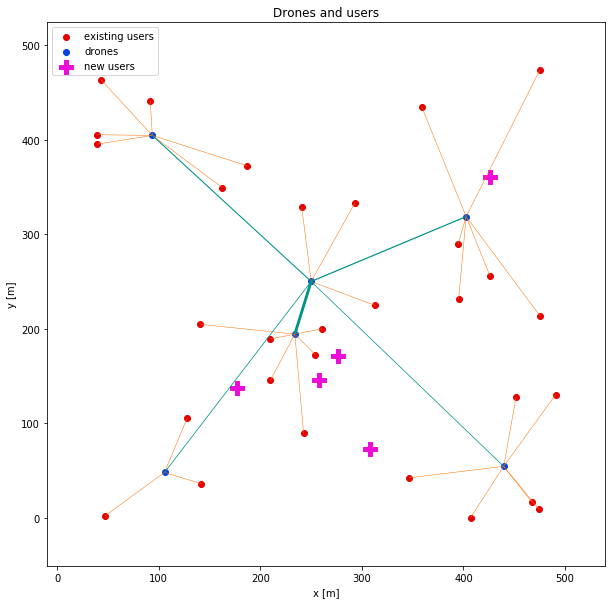

Took 0.46229982376098633 seconds.


In [3]:
start = time.time()

gen = Generator(play_area=500)
gen.generate(drone_count = 5, fixed_count=30, new_count=5, drone_height = 30)
gen.associate_fixed()
gen.generate_matrix(user2drone_B=1000000, user2drone_P=30, drone2base_B=2000000, drone2base_P=30, noise_psd=4*(10**-21))
gen.plot()

end = time.time()
print("Took " + str(end-start) + " seconds.")